In [1]:
import os
import sys

_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from hq.samples_analysis import extract_MAP_sample

os.environ['APOGEE_CACHE_PATH'] = '/mnt/ceph/users/apricewhelan/apogee'
from subframe.data import Visit
from subframe.config import sdss_auth
from subframe.log import logger
from subframe.velocity import normalize_ref_to_frame, cross_correlate
from subframe.utils import parabola_optimum

logger.setLevel(1)

In [7]:
# allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-l33alpha.fits', hdu=1)
# allvisit = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allVisit-dr17-l33alpha.fits', hdu=1)

allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR16/allStar-r12-l33.fits', hdu=1)
allvisit = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR16/allVisit-r12-l33.fits', hdu=1)

In [16]:
shit_mask = ((allstar['VSCATTER'] > 40) &
             (allstar['LOGG'] > 3.5) &
             (allstar['TEFF'] > 3500) & 
             (allstar['TEFF'] < 6500) &
             (allstar['SNR'] > 150) &
             (allstar['NVISITS'] < 15) &
             (allstar['NVISITS'] > 8) & 
             (allstar['APOGEE_ID'] != '2M11291785+4853250') &
             (allstar['TELESCOPE'] == 'apo25m'))
shit_mask.sum()

6

In [17]:
# apid = '2M19241171+3650235' # KOI-984
# apid = '2M11291785+4853250' # variable control star
apid = allstar['APOGEE_ID'][shit_mask][1]
star = allstar[allstar['APOGEE_ID'] == apid]
visits_tbl = allvisit[allvisit['APOGEE_ID'] == apid]

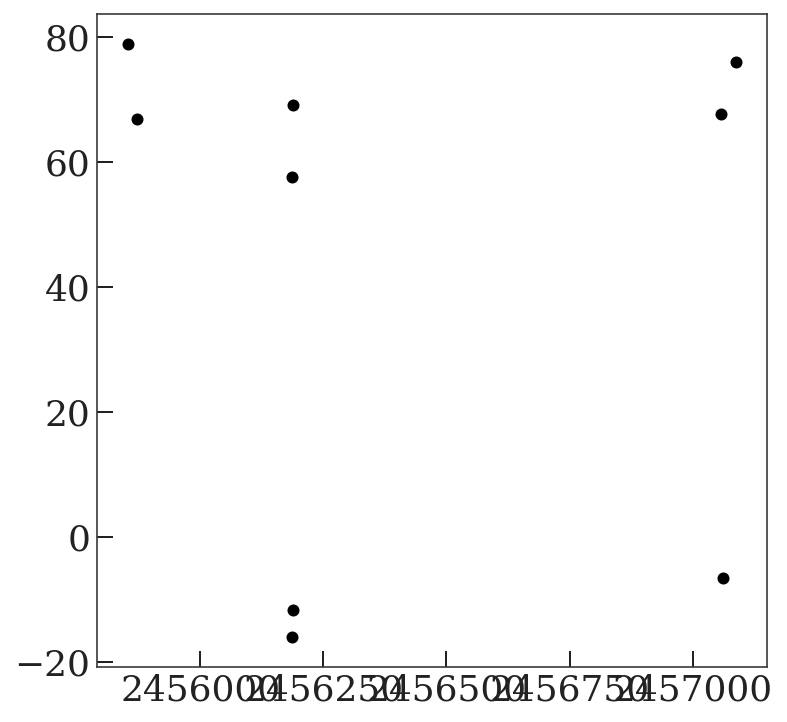

In [18]:
# plt.scatter((visits['JD'] / 0.9631649255752563) % 1., visits['VHELIO'])
# plt.scatter((row['JD'] / 0.9631649255752563) % 1., row['VHELIO'], color='tab:red')
plt.scatter(visits_tbl['JD'], visits_tbl['VHELIO'])

In [ ]:
visits = []
for row in visits_tbl:
    visit = Visit(row)
    visit.frame_times
    visits.append(visit)

DEBUG:subframe:downloading https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/apo25m/180-12/5531/55852/apVisit-r12-5531-55852-205.fits...


DEBUG: downloading https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/apo25m/180-12/5531/55852/apVisit-r12-5531-55852-205.fits... [hq]


DEBUG:subframe:<Response [200]>
DEBUG:subframe:downloading https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/apo25m/180-12/5531/55852/apCframe-a-02900064.fits...


DEBUG: <Response [200]> [hq]
DEBUG: downloading https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/apo25m/180-12/5531/55852/apCframe-a-02900064.fits... [hq]


In [5]:
len(visits)

5

In [ ]:
allstar

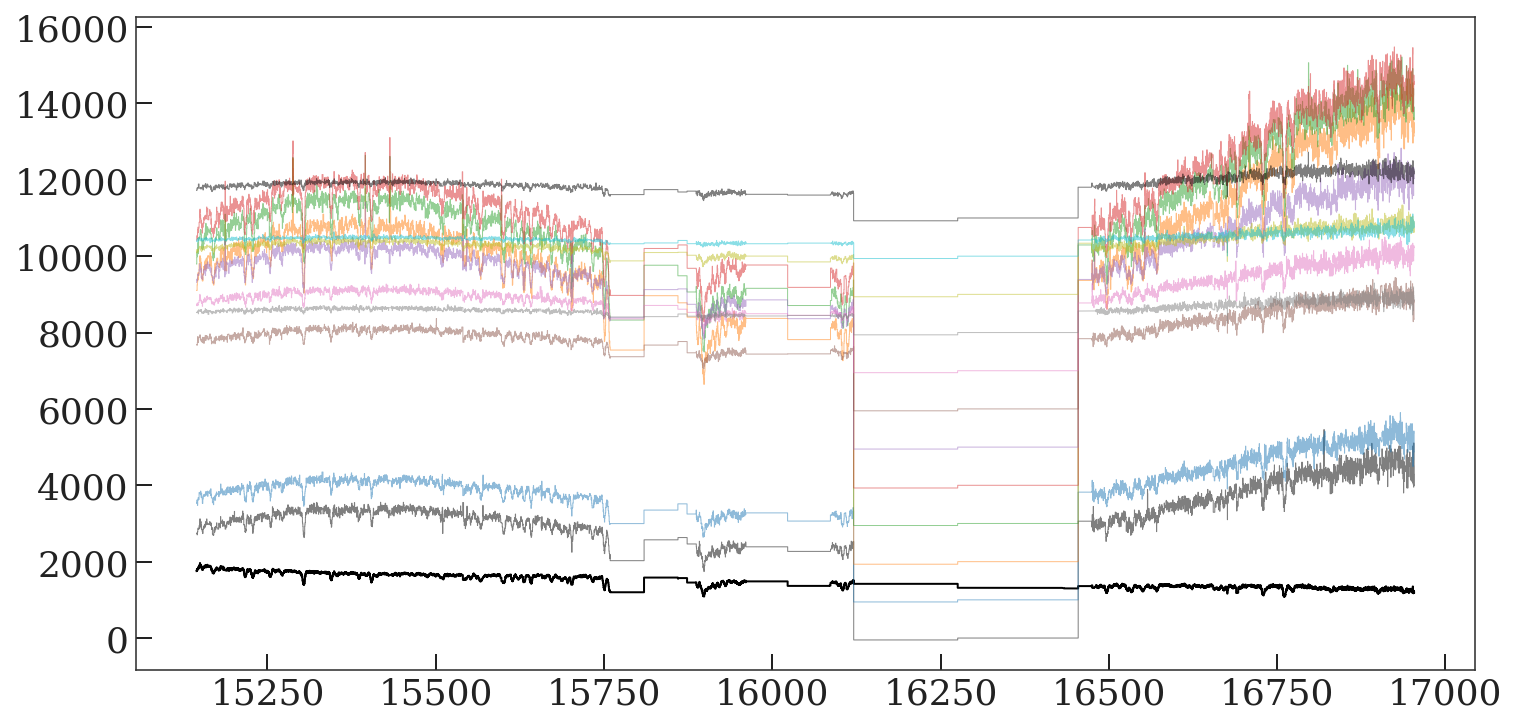

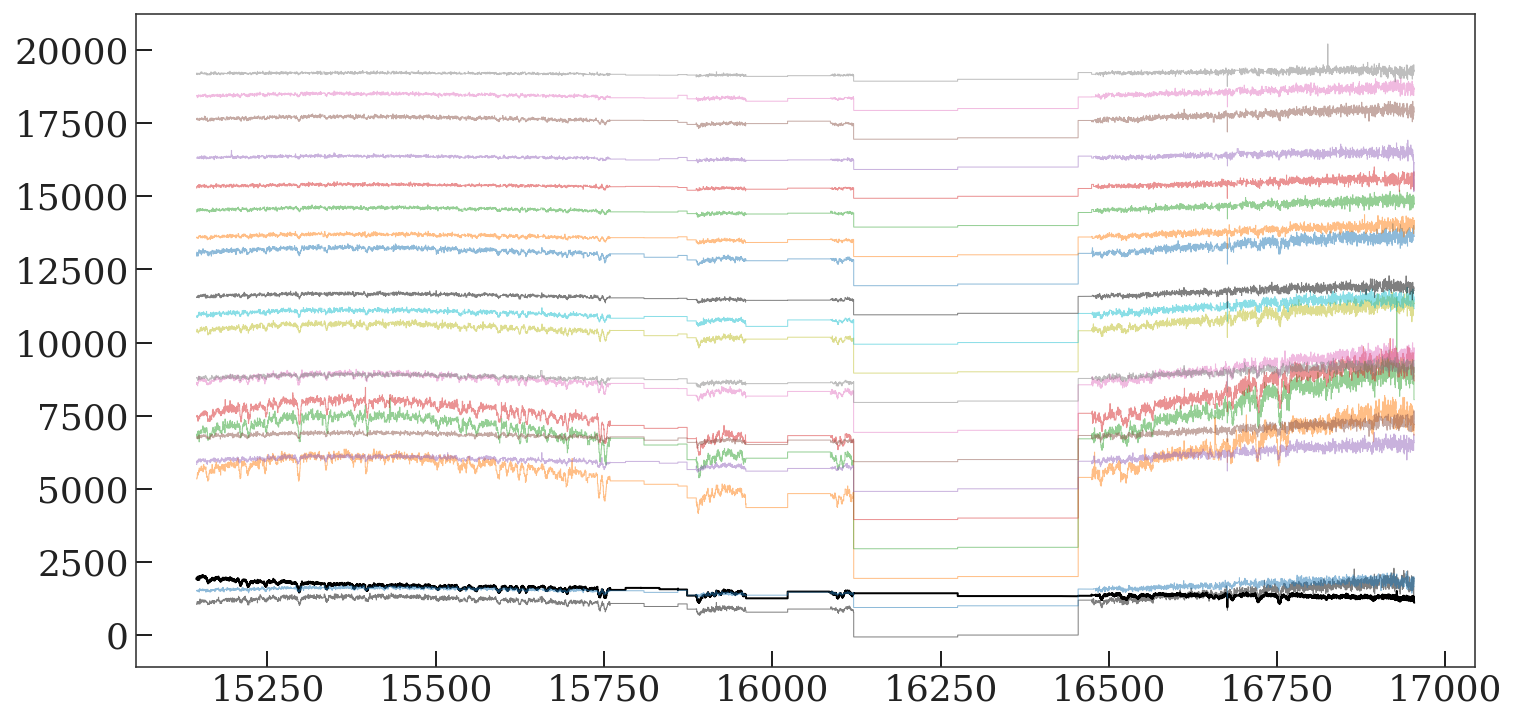

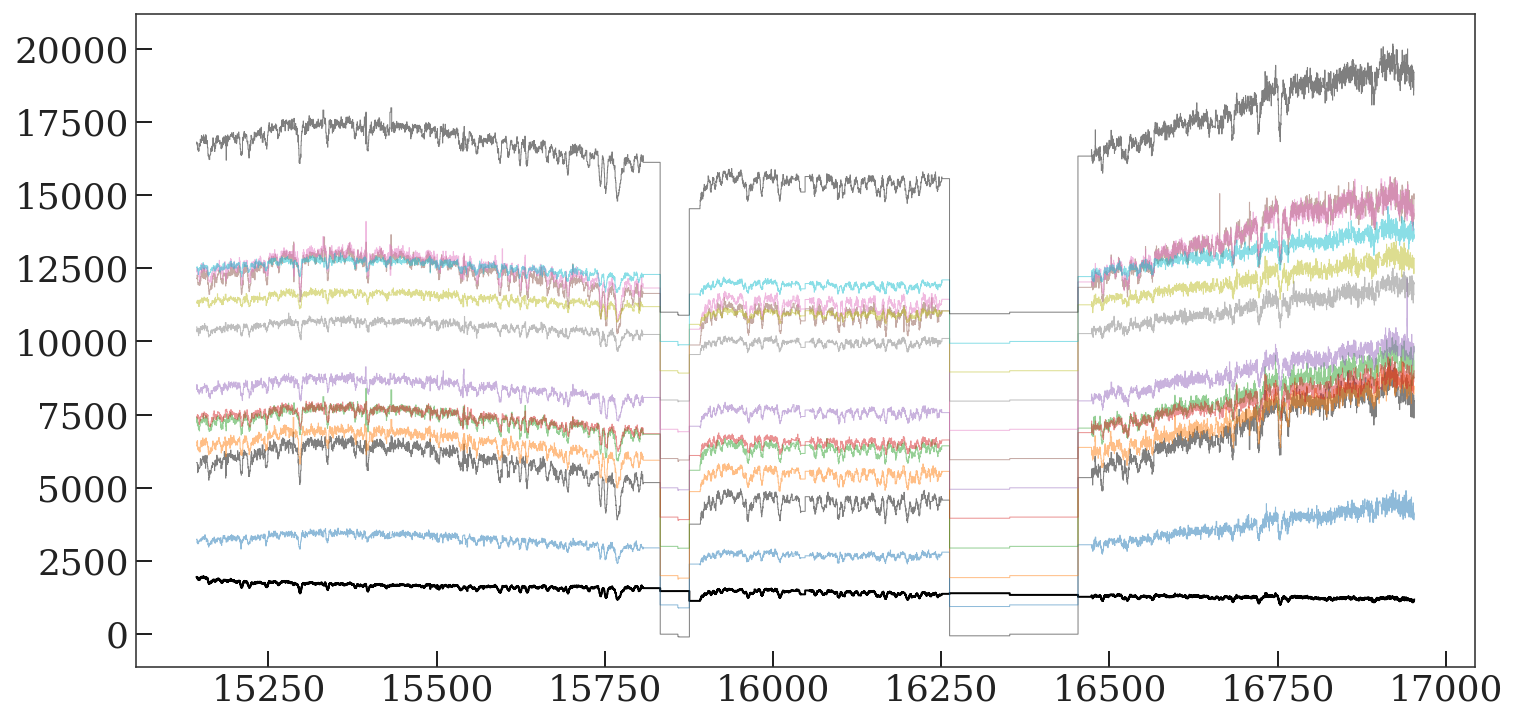

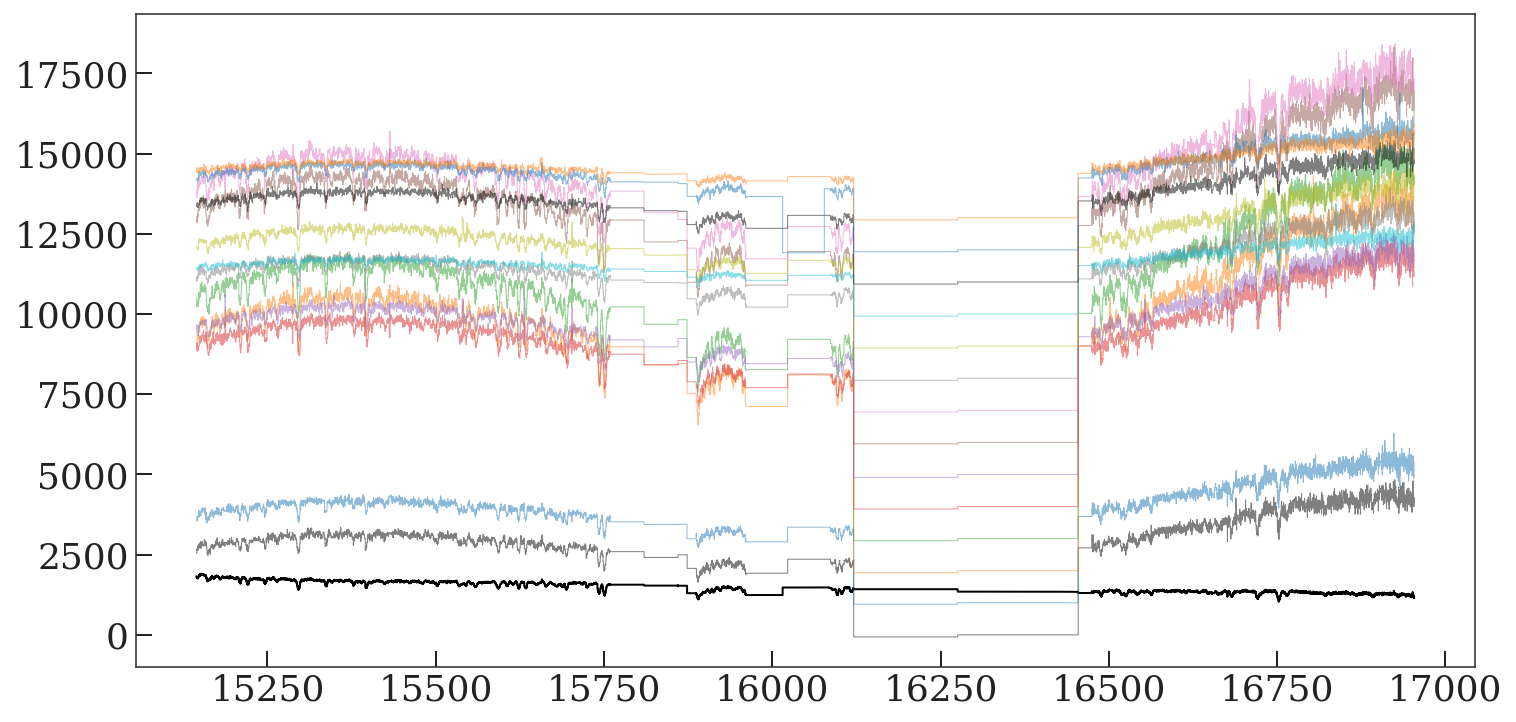

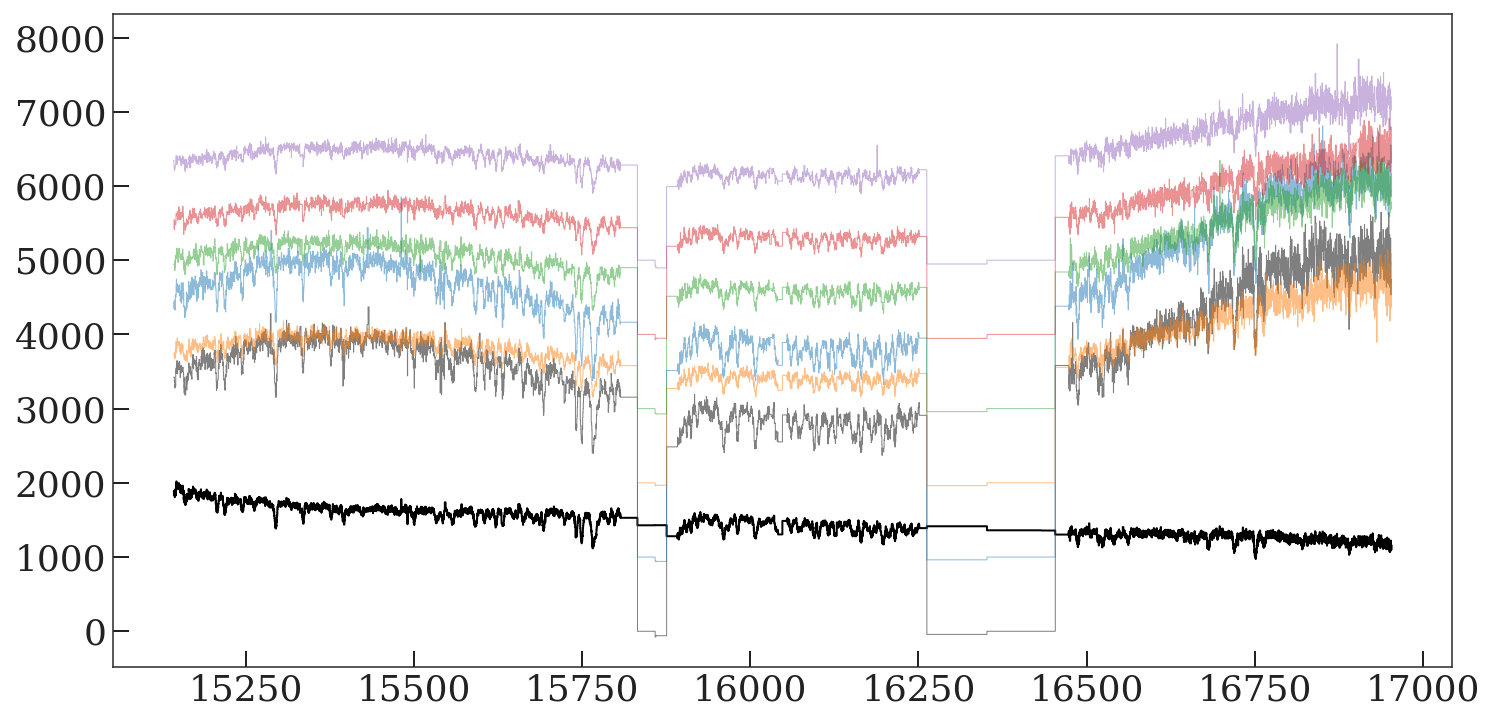

In [7]:
for visit in visits:
    spectra = visit.load_frame_spectra()

    fig = plt.figure(figsize=(12, 6))

    plt.plot(visit.spectrum.wavelength,
             visit.spectrum.flux,
             marker='', ls='-', lw=1,
             drawstyle='steps-mid', alpha=1, color='k')

    for i, s in enumerate(spectra.values()):
        plt.plot(s.wavelength, 
                 s.flux + i*1000, 
                 marker='', ls='-', lw=0.5,
                 drawstyle='steps-mid', alpha=0.5)
        
    fig.set_facecolor('w')

In [8]:
mjds = []
rvs = []

for visit in visits:
    spectra = visit.load_frame_spectra()
    
    for frame, s in spectra.items():
        print(frame)
        
        time = visit.frame_times[frame]
        
        normed_ref_spectrum, clip_mask = normalize_ref_to_frame(
            s, visit.spectrum, sigma_clip_flux=False)
        
        cc, vs = cross_correlate(
            s, normed_ref_spectrum, 
            clip_mask=clip_mask, 
            K_half=1)
        
        cc_dv, cc_poly = parabola_optimum(vs.value, cc)
        
        rvs.append(visit._visit_row['VHELIO'] - cc_dv)
        mjds.append(time.tcb.mjd)

22950020
22950019
22950021
22950022
22950016
22950015
22950017
22950018
22950012
22950014
22950013
22950011
22960028
22960019
22960017
22960030
22960029
22960011
22960012
22960018
22960020
22960027
22960021
22960026
22960024
22960022
22960025
22960014
22960013
22960023
22960016
22960015
19260023
19260021
19260024
19260025
19260031
19260030
19260028
19260029
19260027
19260026
19260020
19260022
22970021
22970022
22970020
22970019
22970012
22970011
22970025
22970026
22970024
22970023
22970016
22970018
22970017
22970015
19230032
19230033
19230035
19230034
19230031
19230030


(370, 380)

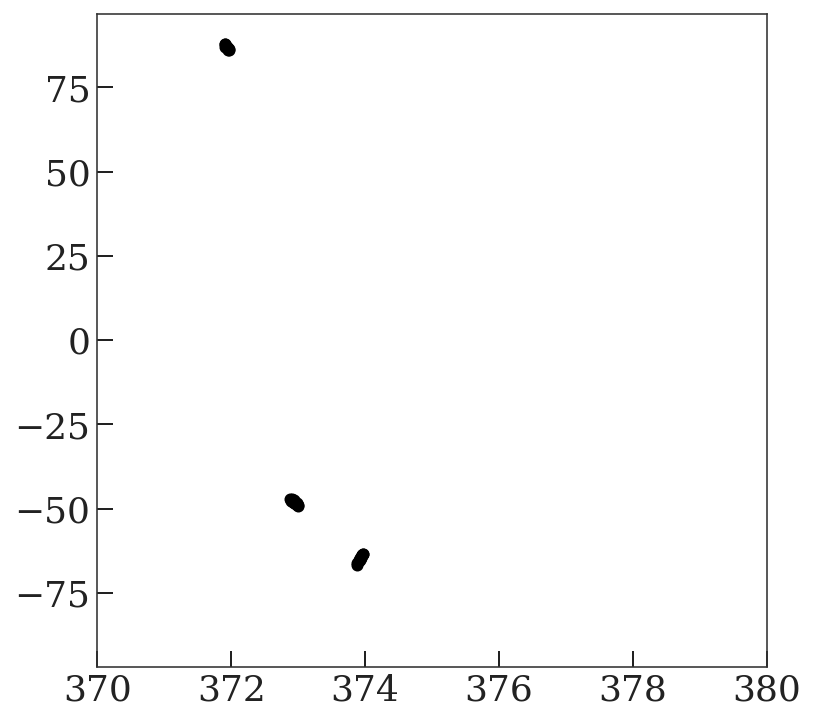

In [13]:
plt.scatter(mjds - min(mjds), rvs)
plt.xlim(370, 380)

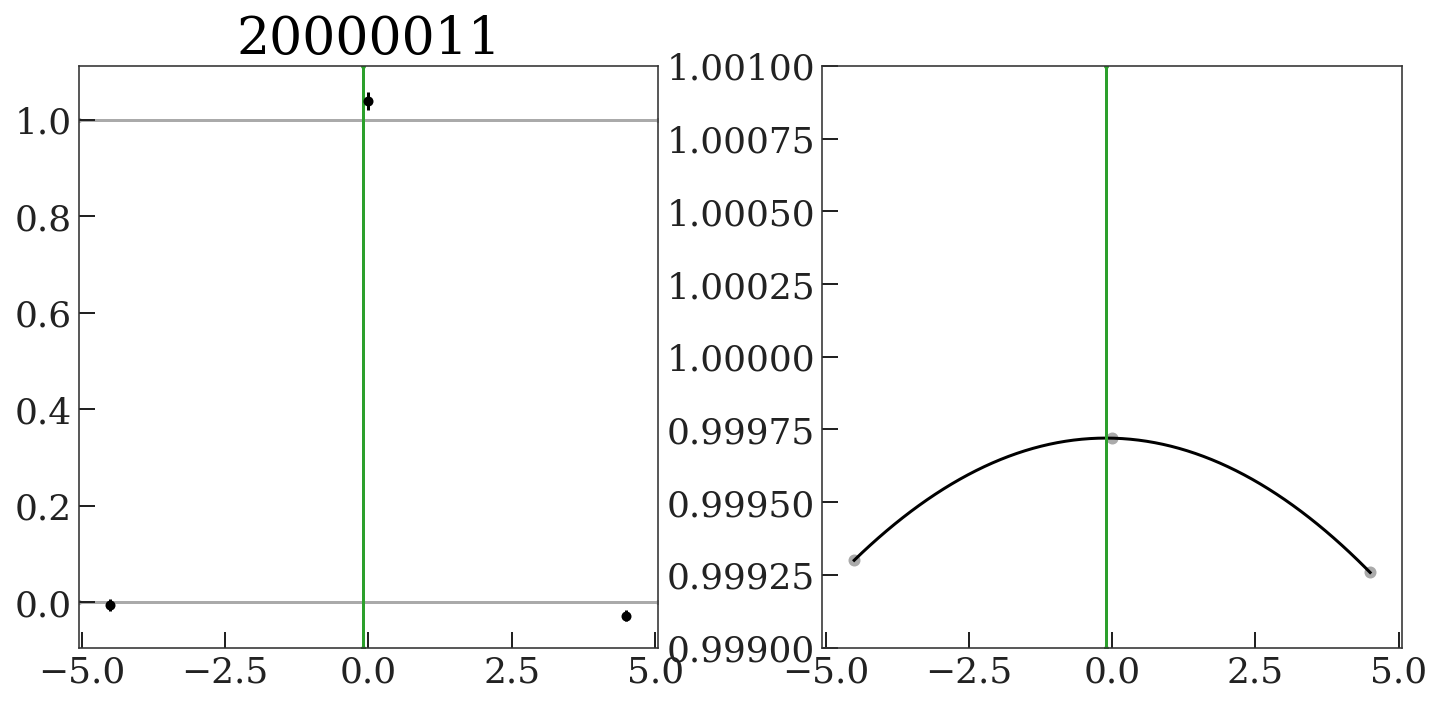

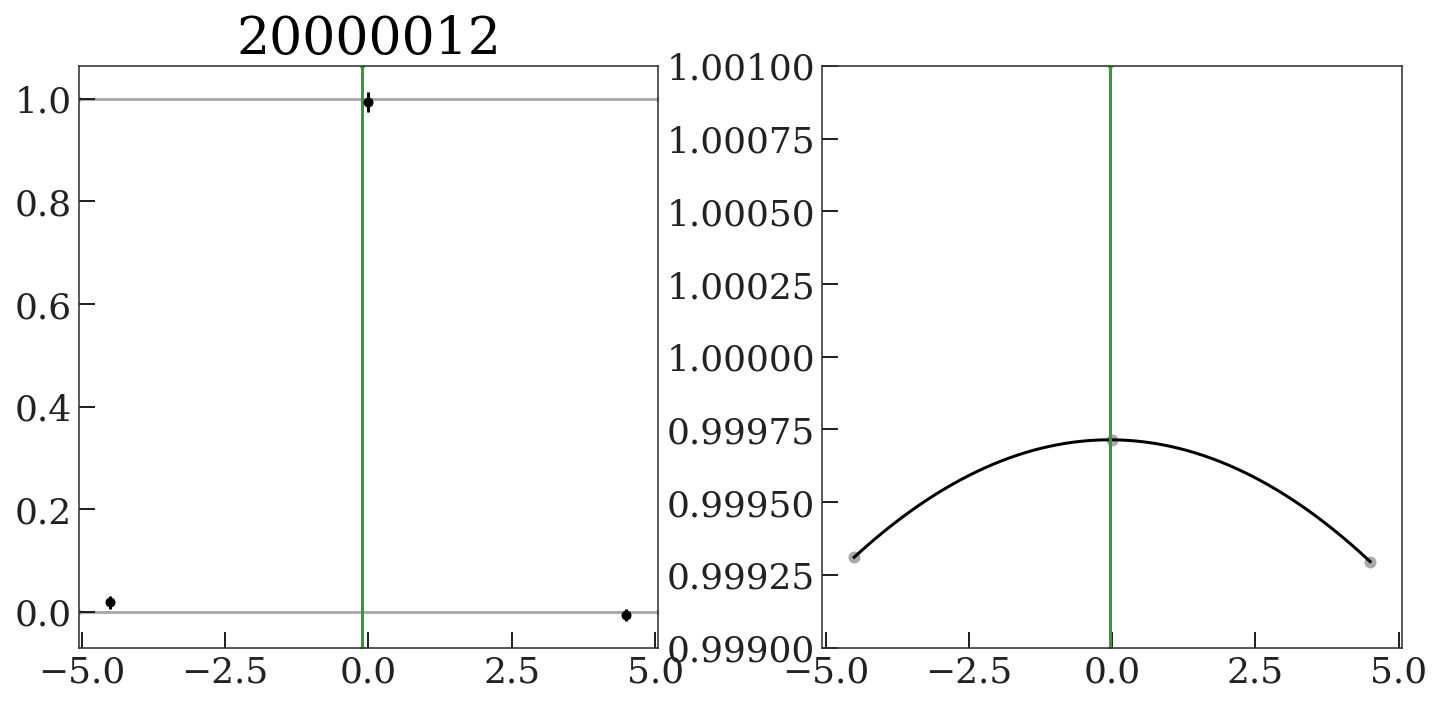

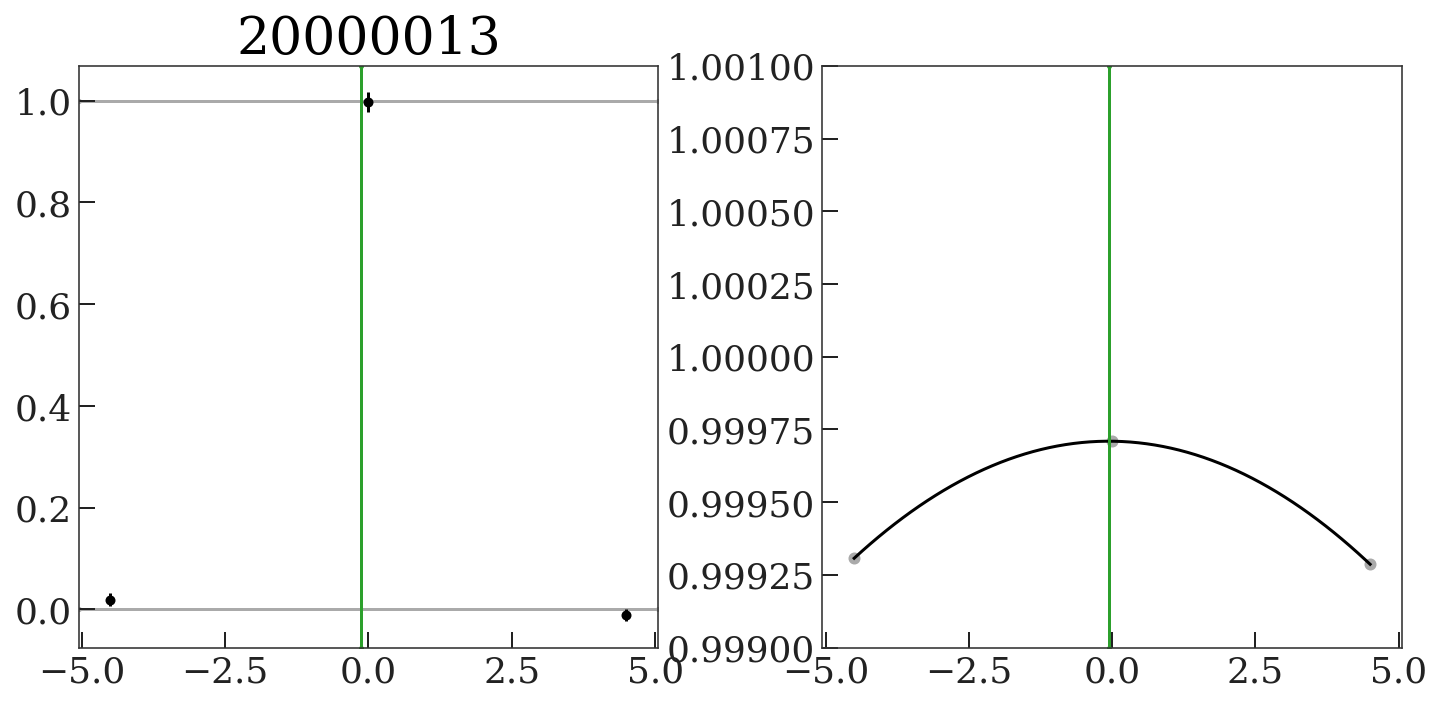

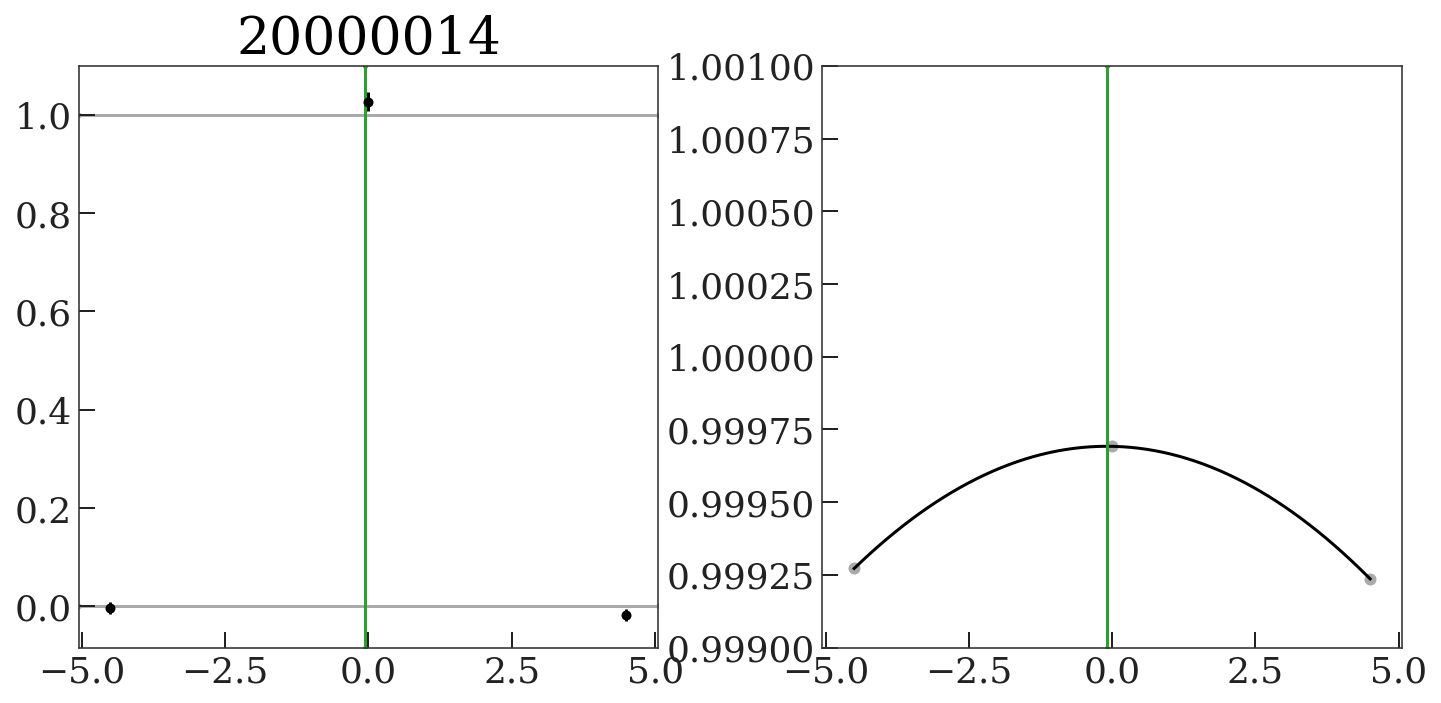

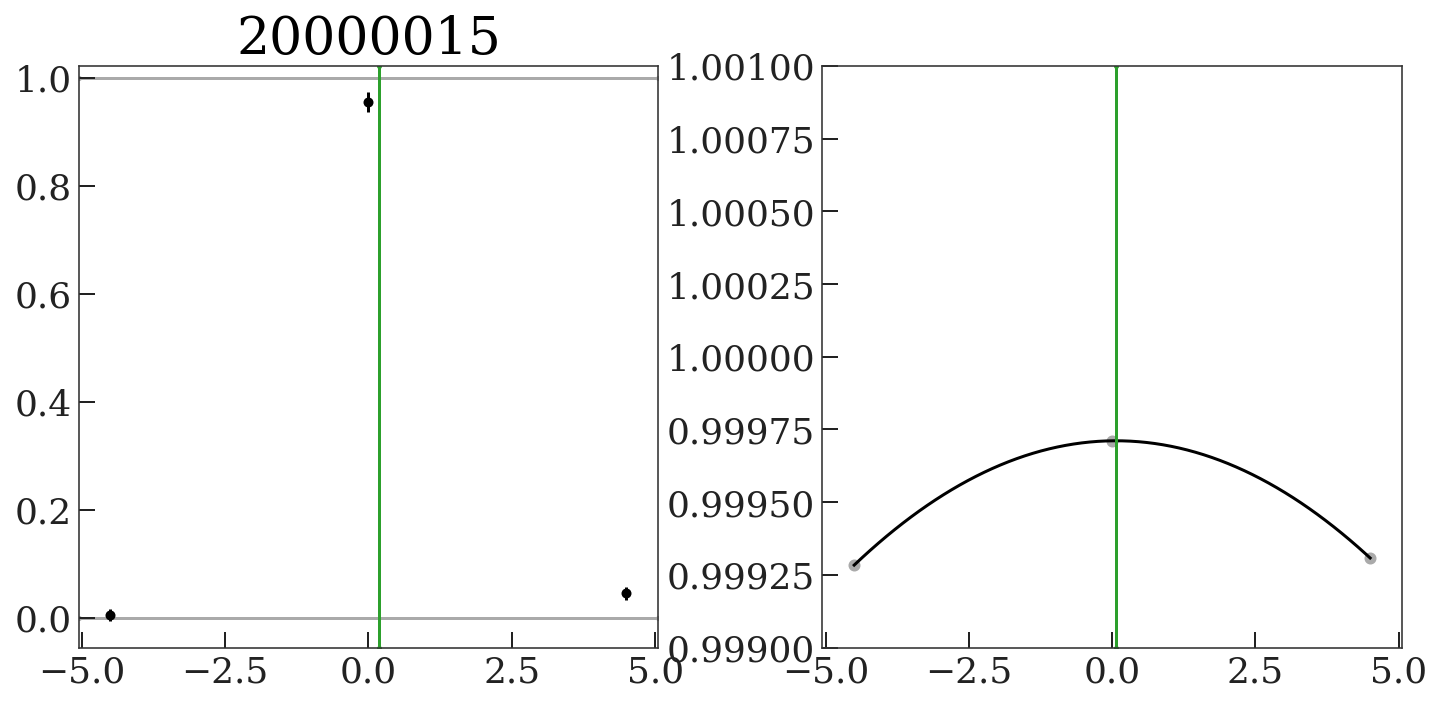

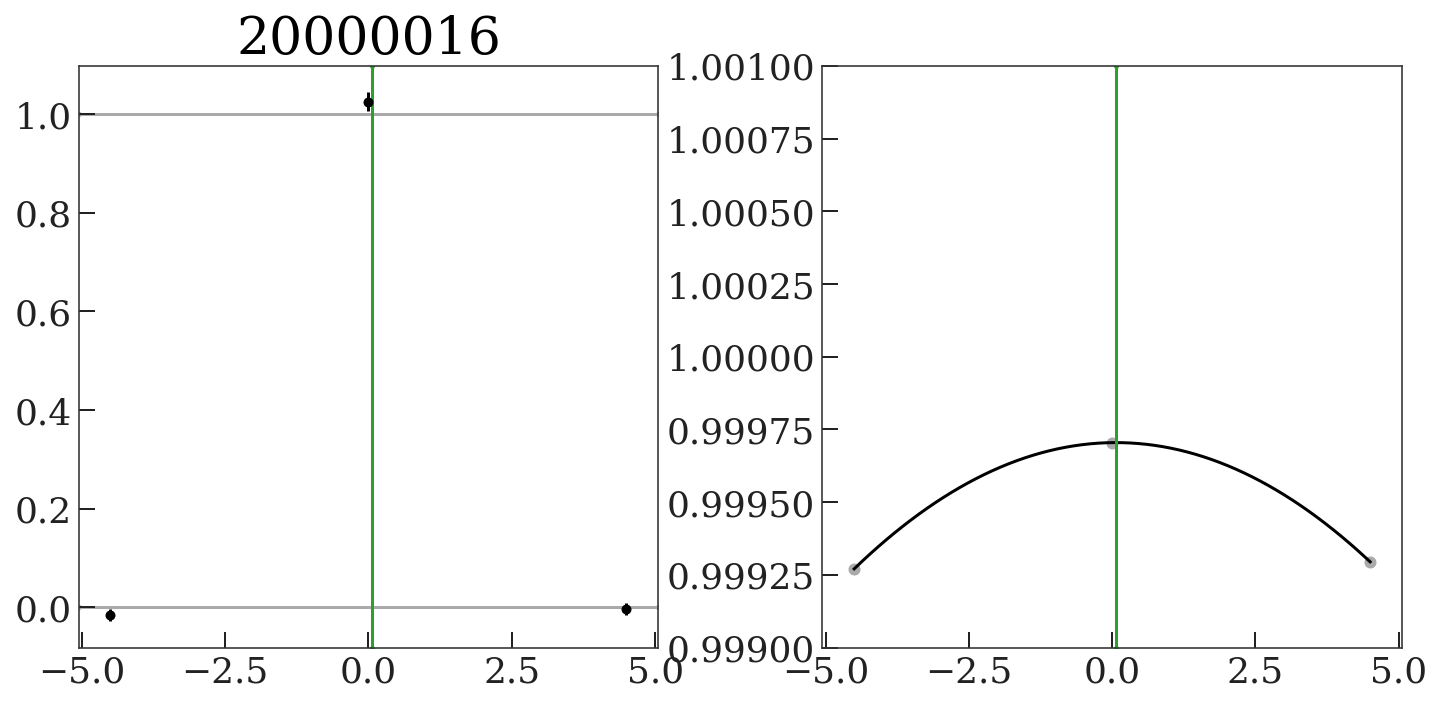

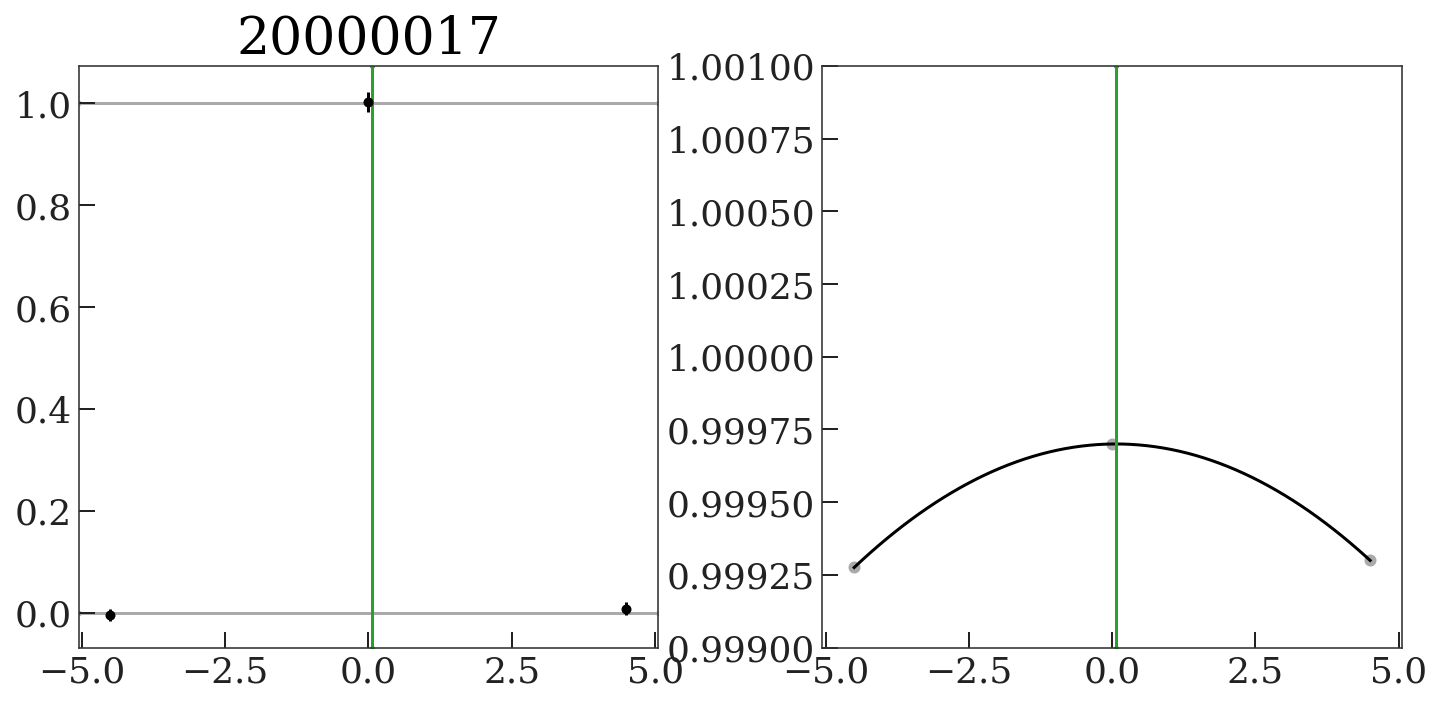

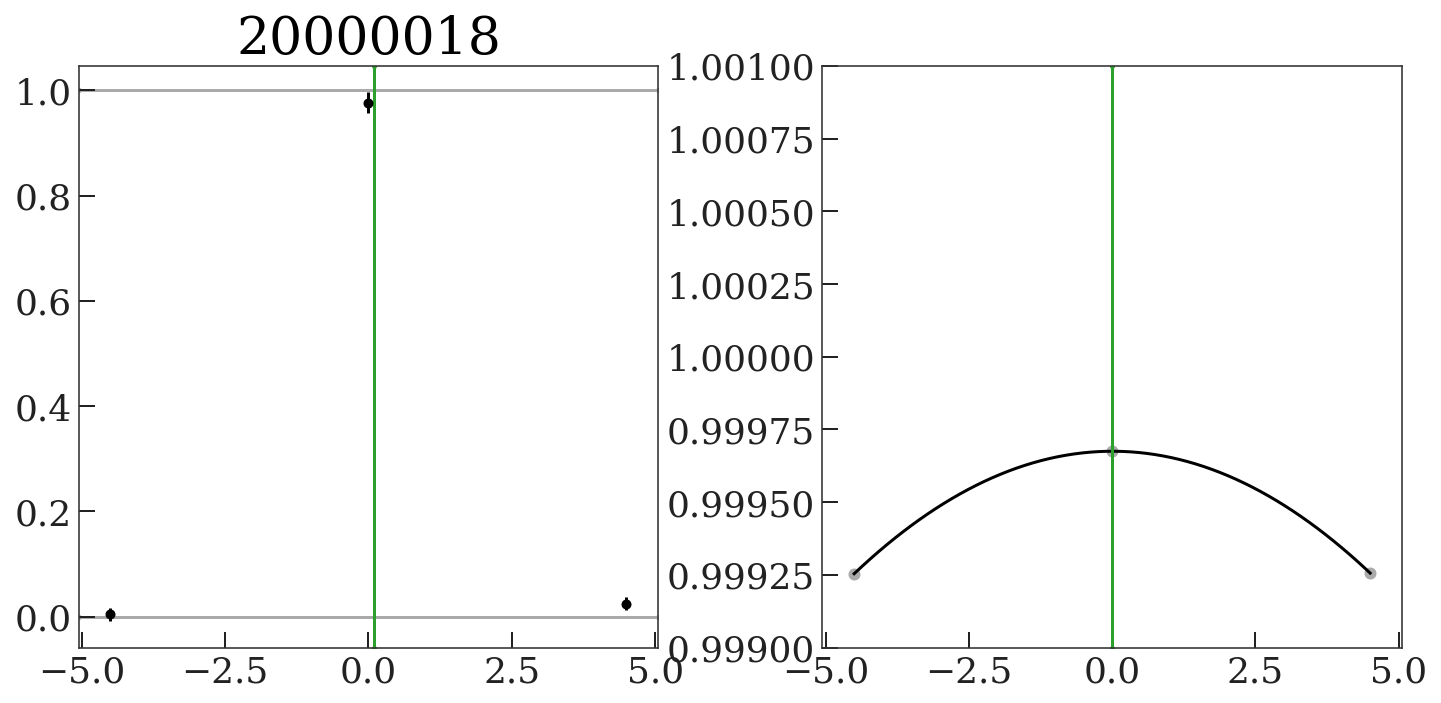

In [78]:
mjds = []
dvs = []
cc_dvs = []
for frame, s in sorted(spectra.items(), key=lambda x: int(x[0])):
    mjds.append(visit.frame_times[frame].mjd)
    
    normed_ref_spectrum, clip_mask = normalize_ref_to_frame(s, visit.spectrum, 
                                                            sigma_clip=False)
    kernel, kernel_cov, vs, cc = estimate_kernel(
        s, normed_ref_spectrum, 
        clip_mask=clip_mask, 
        K_half=1)
    
    cc_dv, cc_poly = parabola_hack(vs.value, cc)
    
    dvs.append(np.sum(kernel * vs.value) / np.sum(kernel))
    cc_dvs.append(cc_dv)
    
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(normed_ref_spectrum.wavelength.value,
#              normed_ref_spectrum.flux,
#              marker='', ls='-', lw=1,
#              drawstyle='steps-mid', alpha=0.7)
#     plt.plot(s.wavelength.value,
#              s.flux,
#              marker='', ls='-', lw=1,
#              drawstyle='steps-mid', alpha=0.7)
#     plt.xlim(16500, 16700)
#     # plt.ylim(0.5, 1.5)
    
#     if clip_mask is not None:
#         for val in s.wavelength.value[clip_mask]:
#             plt.axvline(val, color='tab:red', alpha=0.2, zorder=-100)
    
    # ---
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                             sharex=True)
    
    ax = axes[0]
    ax.errorbar(vs.value, kernel, np.sqrt(np.diag(kernel_cov)),
                marker='o', ls='none')
    
    ax.axhline(0, zorder=-10, color='#aaaaaa')
    ax.axhline(1, zorder=-10, color='#aaaaaa')
    ax.axvline(np.sum(kernel * vs.value) / np.sum(kernel), 
               color='tab:green')
    ax.set_title(frame)
    
    ax = axes[1]
    
    ax.scatter(vs.value, cc, color='#aaaaaa')
    grid = np.linspace(vs.value.min(), vs.value.max(), 128)
    ax.plot(grid, cc_poly(grid), marker='')
    ax.axvline(cc_dv, color='tab:green')
    ax.set_ylim(0.999, 1.001)
    
    fig.tight_layout()

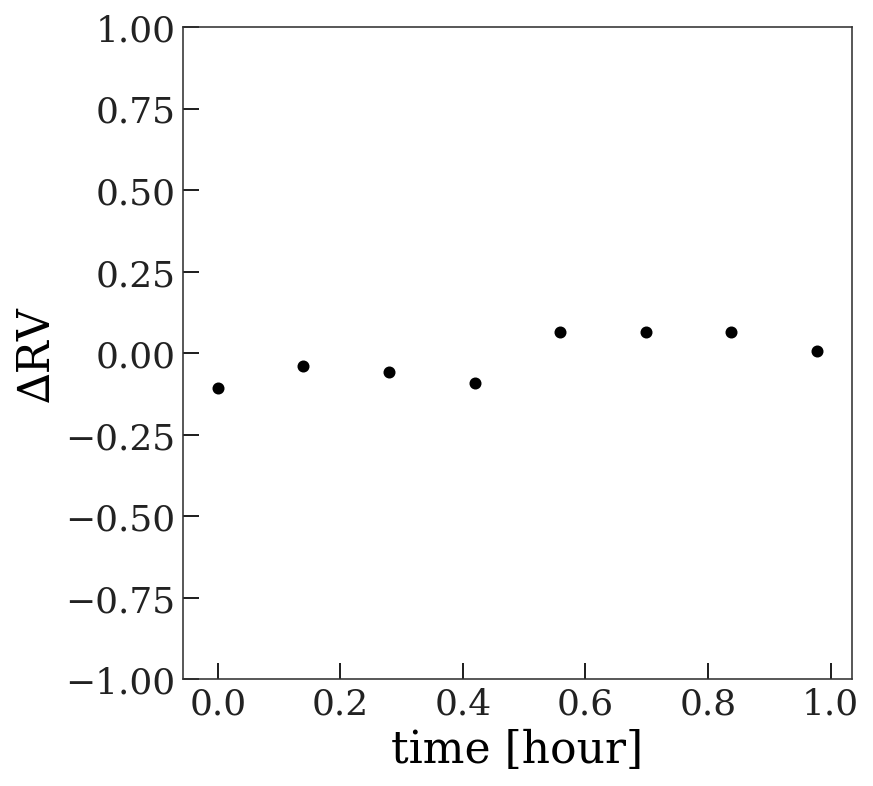

In [79]:
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(dvs))
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(cc_dvs))
# plt.plot(np.array(mjds) - min(mjds), orbit.radial_velocity(Time(mjds, format='mjd')))

fig = plt.figure()
# plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(dvs))
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(cc_dvs))
plt.xlabel('time [hour]')
plt.ylabel('∆RV')
# plt.ylim(-5, 5)
plt.ylim(-1, 1)
fig.set_facecolor('w')

### TODO

- Multiple visits
- Plot visit velocities and frame velocities
- Compare stitching CC's and centroided velocities
- Improve the CC code to best practices (subtract the mean?)